# Optimial parameterization vs noise


In [1]:
# %pip install -q jax jaxlib numpyro numpy matplotlib funsor seaborn xarray
import __init__
import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
from numpyro import distributions as dists


import numpy as np

from matplotlib import pyplot as plt
plt.style.use('ggplot')
jax.config.update("jax_enable_x64", True)
# set linecolors to tab10
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
from matplotlib.patches import Rectangle
from adim import *
from matplotlib.ticker import MaxNLocator, MultipleLocator
from matplotlib.transforms import Bbox, TransformedBbox
from mpl_toolkits.axes_grid1.inset_locator import BboxConnectorPatch

Adding '/Users/johannes/Projects/Optimal Thresholds for Approximate Analog In-Memory Computing' to path...


In [84]:


def plot_panel(
    ax,
    vector_length,
    thresholds,
    noise_std,
    threshold_kwargs=dict(linestyle=":", linewidth=1, color="black"),
    inside_color="C0",
    outside_color="C1",
    inset_color=None,
    zoom_connector_kwargs=dict(loc1a=3, loc1b=4, loc2a=2, loc2b=1, ec="black"),
    titles = ["", "", ""],
    title_loc = "left",
    distribution="bipolar", 
    fixed=0,
    yscale=1,
    zoom = None
):
    fig = ax[0].get_figure()
    ax_density, ax_zoomed = ax

    tmin, tmax = float(thresholds[1]), float(thresholds[-2])
    

    # compute the "background" probability distribution
    nn = np.arange(vector_length + 1) * 2 - vector_length
    # pp = np.exp(dists.Binomial(vector_length, 0.5).log_prob(xx))
    p_n = jnp.exp(
        log_pdf_n(
            nn, vector_length=vector_length, distribution=distribution, fixed=fixed
        )
    )

    if zoom is not None:
        xmin, ymin, xmax, ymax = float(zoom[0]), float(zoom[1]), float(zoom[2]), float(zoom[3])
    else:
        xmin, xmax = tmin - 10, tmax + 10
        ymin, ymax = -p_n.max() * yscale * 0.05, p_n.max() * yscale * 1.05

    # create the density plot

    # compute area between thresholds
    total = p_n.sum(where=(tmin <= nn) * (nn <= tmax))
    rect = Rectangle(
        (xmin, ymin), xmax - xmin, ymax - ymin, edgecolor="black", facecolor=inset_color
    )

    p_x = jnp.exp(
        log_pdf_x(
            nn, vector_length=vector_length, distribution=distribution, fixed=fixed
        )
    )

    ax_density.add_patch(rect)
    # ax.fill_between(nn, ymax, p_n, where=(nn >= xmin) * (nn <= xmax), color=threshold_color)
    ax_density.fill_between(
        nn,
        p_x * yscale,
        0,
        where=(nn >= tmin) * (nn <= tmax),
        color=inside_color,
        alpha=0.5,
        label=f"in range\n({100*total:.1f}%)",
    )
    ax_density.fill_between(
        nn,
        p_x * yscale,
        0,
        where=np.logical_not((nn >= tmin) * (nn <= tmax)),
        color=outside_color,
        alpha=0.5,
        label=f"clipped\n({100*(1-total):.1f}%)",
    )
    # ax.vlines([opt_thresholds[1],opt_thresholds[-2]], 0, ymax, color=threshold_color)
    ax_density.plot(nn, p_x * yscale, color="gray")

    # create the zoomed-in plot
    xx = np.linspace(xmin, xmax, 1001)

    p_x = jnp.exp(
        log_pdf_x(
            xx,
            noise_std=noise_std,
            vector_length=vector_length,
            distribution=distribution,
            fixed=fixed,
        )
    )
    p_n = jnp.exp(
        log_pdf_n(
            nn, vector_length=vector_length, distribution=distribution, fixed=fixed
        )
    )

    c = BboxConnectorPatch(
        TransformedBbox(rect.get_bbox(), ax_density.transData),
        ax_zoomed.bbox,
        **zoom_connector_kwargs,
        clip_on=False,
    )

    ax_zoomed.add_patch(c)
    c.set_in_layout(False)

    idx_in = (tmin <= xx) * (xx <= tmax)
    ax_zoomed.patch.set_color(inset_color)
    ax_zoomed.fill_between(xx, p_x * yscale, 0, where=idx_in, color=inside_color, alpha=0.5)
    ax_zoomed.fill_between(
        xx, p_x * yscale, 0, where=np.logical_not(idx_in), color=outside_color, alpha=0.5
    )
    # ax_zoomed.plot(xx, p_x, color="gray")

    # ax_density.legend(loc="lower center", bbox_to_anchor=(0.5, 0.95), fancybox=False, facecolor="none", edgecolor="none", ncol=4)

    ax_zoomed.set_xlabel("real input (zoomed)")

    # for t in thresholds:
        # ax_zoomed.axvline(t, **threshold_kwargs)
        
    ax_zoomed.set_ylim(ymin, ymax)
    print(xmin, xmax)
    ax_zoomed.set_xlim(xmin, xmax)

    ax_density.set_yticks([])
    ax_zoomed.set_yticks([])

    ax_zoomed.set_frame_on(True)
    for spine in ax_zoomed.spines.values():
        plt.setp(spine, color="black")

    ax_density.set_title(titles[0], loc=title_loc)
    ax_zoomed.set_title(titles[1], loc=title_loc)

    return fig, ax_density

In [134]:
vector_length = 256
num_bits = jnp.array([4,5,6])
phase = jnp.array([-3.0, -2.5, -2.0, -1.5, -1.0, -0.5, 0.0]) #jnp.linspace(-2, 2, 10)
scale = jnp.logspace(-1, 2, 100)

noise_std = jnp.logspace(-2, 1, 100)

kappa = jnp.array([2.82247199, 3.21433549, 3.51495091])
w_opt = jnp.sqrt(noise_std**2 + 256)[None, :]*kappa[:, None]

# construct distribution
d = dists.Binomial(256, 0.5)
support = d.enumerate_support()
logp = d.log_prob(support)
support = ((support - support.mean())*2).astype(int)
d = EmpiricalDistribution(support, jnp.exp(logp))

MIs = sweep(
    d,
    num_bits,
    phase,
    scale,
    noise_std,
)

100%|██████████| 3/3 [00:28<00:00,  9.50s/it]


In [135]:
max_phase_idx = []
max_scale_idx = []
max_MI = []
for i in range(len(num_bits)):
    max_phase_idx.append([])
    max_scale_idx.append([])
    max_MI.append([])
    for j in range(len(noise_std)):
        i1,i2 = jnp.unravel_index(MIs[i, j, ...].argmax(), MIs[i, j, ...].shape)
        max_phase_idx[i].append(i1)
        max_scale_idx[i].append(i2)
        max_MI[i].append(MIs[i,j,i1,i2])
max_phase_idx = jnp.array(max_phase_idx)
max_scale_idx = jnp.array(max_scale_idx)
max_MI = jnp.array(max_MI)

In [136]:
max_scale = scale[max_scale_idx]
max_width = max_scale*(2**num_bits[:, jnp.newaxis]-2)
max_phase = phase[max_phase_idx]

-3.0 3.0
-3.0 3.0
-3.0 3.0


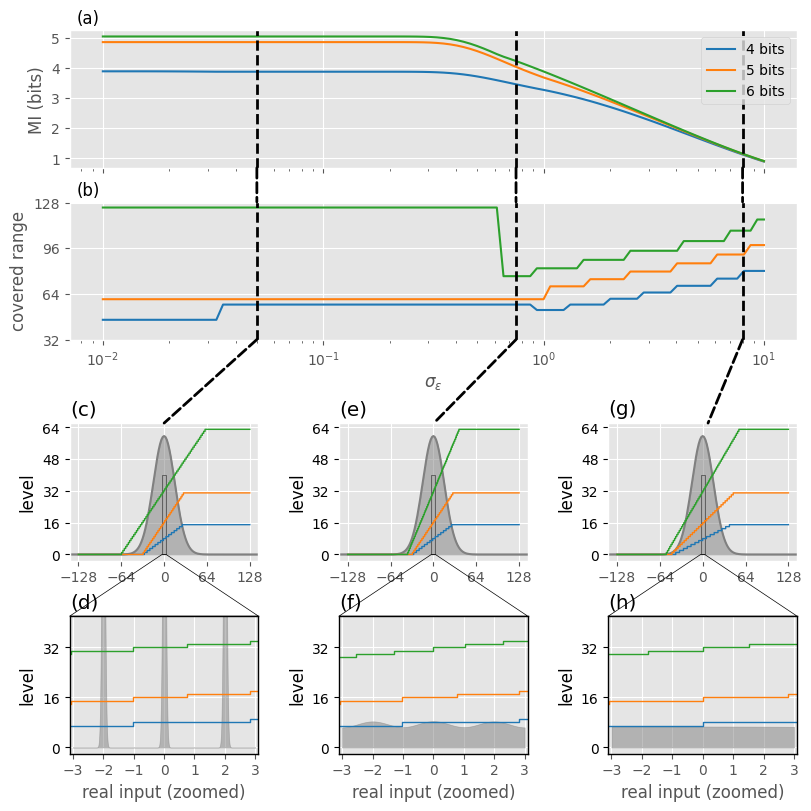

In [174]:
from matplotlib import transforms
from matplotlib.patches import ConnectionPatch


fig, ax = plt.subplot_mosaic(
    [
        ["MI", "MI", "MI"],
        ["scale", "scale", "scale"],
        ["dist 1", "dist 2", "dist 3"],
        ["zoom 1", "zoom 2", "zoom 3"],
    ],
    figsize=(8, 8),
    height_ratios=[1,1,1,1],
    constrained_layout=True,
)

lines = []
# lines += ax["MI"].semilogx(
#     noise_std, enob(.T), linestyle="--", color="black", label="ENOB"
# )
lines += ax["MI"].semilogx(
    noise_std, max_MI.squeeze().T, label=[f"{int(n)} bits" for n in num_bits]
)


ax["scale"].semilogx(noise_std, max_width.squeeze().T)
plt.setp(ax["MI"].get_xticklabels(), visible=False)
ax["scale"].sharex(ax["MI"])

ax["MI"].legend(handles=lines, loc="upper right")


line_connector_kwargs=dict(linewidth=2, linestyle="--", color="black")

ax["MI"].set_yticks([1,2,3,4,5])
ax["MI"].set_ylabel("MI (bits)")
ax["scale"].set_ylabel("covered range")
ax["scale"].set_yticks([32, 64, 96, 128])

# ax["MI"].set_title("Mutual Information vs noise for different bitwidths")
# ax["scale"].set_title("Optimal Scale")
ax["scale"].set_xlabel("$\\sigma_\\varepsilon$")

ax["MI"].annotate("(a)", (0.01, 1.05), xycoords="axes fraction", fontsize=12)
ax["scale"].annotate("(b)", (0.01, 1.05), xycoords="axes fraction", fontsize=12)

for i, (sig, ax_dist, ax_zoom) in enumerate([(0.05, ax["dist 1"], ax["zoom 1"]), (0.75, ax["dist 2"], ax["zoom 2"]), (8.0, ax["dist 3"], ax["zoom 3"])]):
    ax["MI"].axvline(sig, **line_connector_kwargs)
    ax["scale"].axvline(sig, **line_connector_kwargs)

    # plot line from scale axis to diat 1 axis
    con = ConnectionPatch(
        xyA=(sig, 0.0),
        xyB=(sig, 1.0),
        coordsA=transforms.blended_transform_factory(
            ax["MI"].transData, ax["MI"].transAxes
        ),
        coordsB=transforms.blended_transform_factory(
            ax["scale"].transData, ax["scale"].transAxes
        ),
        axesA=ax["MI"],
        axesB=ax["scale"],
        **line_connector_kwargs
    )
    fig.add_artist(con)
    con.set_in_layout(False)

    # plot line from scale axis to diat 1 axis
    con = ConnectionPatch(
        xyA=(sig, 0.0),
        xyB=(sig, 1.0),
        coordsA=transforms.blended_transform_factory(
            ax["scale"].transData, ax["scale"].transAxes
        ),
        coordsB=transforms.blended_transform_factory(
            ax_dist.transData, ax_dist.transAxes
        ),
        axesA=ax["scale"],
        axesB=ax_dist,
        **line_connector_kwargs
    )
    fig.add_artist(con)
    con.set_in_layout(False)

    s = float(max_scale[0, idx])
    p = float(max_phase[0, idx])
    plot_panel(
        [ax_dist, ax_zoom],
        vector_length,
        [-jnp.inf, jnp.inf],
        sig,
        zoom=(-3, 0, 3, 40),
        inset_color=(0.8, 0.8, 0.8, 0.5),
        titles=[["(c)", "(d)"],["(e)", "(f)"], ["(g)", "(h)"]][i],
        yscale = 300,
        inside_color="gray",
        outside_color="gray",
    )

    # get index corrsponding to sig
    idx = int(jnp.searchsorted(noise_std, sig))
    for j,b in enumerate(num_bits):
        s = float(max_scale[j, idx])
        p = float(max_phase[j, idx])
        thresh = compute_even_levels(2**b, s, p).squeeze()
        plot_quantization(ax_dist, thresh, twinaxis=False, linecolor=f"C{j}", xmin=-128, xmax=128, xticklocator=MultipleLocator(64), yticklocator=MultipleLocator(16))
        plot_quantization(ax_zoom, thresh, twinaxis=False, linecolor=f"C{j}", xmin=-128, xmax=128, xticklocator=MultipleLocator(1), yticklocator=MultipleLocator(16))
    ax_zoom.set_xlim(-3.1, 3.1)
    ax_zoom.set_ylim(-0.05*40, 1.05*40)
    # ax_dist.set_xlim(-128, 128)

# ax["scale"].plot(noise_std, jnp.log2(noise_std)*9+65)
# ax["scale"].plot(noise_std, w_opt.T*1.4)

In [116]:
fig.savefig("../figures/noise.pdf", bbox_inches="tight")
fig.savefig("../figures/noise.svg", bbox_inches="tight")
fig.savefig("../figures/noise.png", bbox_inches="tight", dpi=300)